In [19]:
import pandas as pd

#Loading cleaned Dataset and Viewing It
df = pd.read_csv("clean2.csv")
df.head()

,_id,group_id,num_requests,status_name,status_code,dept,request_type_id,create_date_et,last_action_et,closed_date_et,origin,neighborhood,council_district,request_type_name,resolution_time,is_closed,public_access_level,closed_date_filled,resolution_time_filled,request_status
0,813886,925468,1,closed,1,Police - Zones 1-6,297,2025-01-30 23:43:00,2025-02-03T15:11:00,2025-02-03 15:11:00,Website,Greenfield,5.0,Excessive Noise/Disturbances,3.0,1,Neighborhood,2025-02-03 15:11:00,3,less than 30 days
1,813885,925467,1,closed,1,Pittsburgh Water and Sewer Authority,532,2025-01-30 22:43:00,2025-01-31T08:05:00,2025-01-31 08:05:00,Report2Gov Website,Perry South,6.0,Water Main Break,0.0,1,Block Level,2025-01-31 08:05:00,0,less than 30 days
2,813884,925466,1,in progress,3,DPW - Street Maintenance,484,2025-01-30 21:45:00,2025-01-31T06:27:00,NaN,Website,Shadyside,8.0,Potholes,NaN,0,Block Level,2025-04-06 00:00:00,65,more than 30 days
3,813883,925465,1,in progress,3,DPW - Street Maintenance,484,2025-01-30 20:07:00,2025-01-31T06:27:00,NaN,Website,East Liberty,9.0,Potholes,NaN,0,Block Level,2025-04-06 00:00:00,65,more than 30 days
4,813881,925464,1,open,0,Police - AVU,415,2025-01-30 19:57:00,2025-01-30T19:57:00,NaN,Website,Perry South,6.0,Abandoned Vehicle (parked on street),NaN,0,Neighborhood,2025-04-06 00:00:00,65,more than 30 days


In [20]:
df.isnull().sum().sort_values(ascending=False) #An overview of missing values 

resolution_time           50225
closed_date_et            50225
neighborhood              19288
council_district          18490
public_access_level       18097
request_type_name          5477
dept                       1452
_id                           0
resolution_time_filled        0
closed_date_filled            0
is_closed                     0
origin                        0
group_id                      0
last_action_et                0
create_date_et                0
request_type_id               0
status_code                   0
status_name                   0
num_requests                  0
request_status                0
dtype: int64

In [21]:
df[['create_date_et', 'closed_date_et', 'closed_date_filled', 'resolution_time', 'resolution_time_filled']].sample(5) #Viewing how the data for closed_date_et and resolution_time was dealt


,create_date_et,closed_date_et,closed_date_filled,resolution_time,resolution_time_filled
157177,2023-07-21 09:39:00,2024-08-08 13:17:00,2024-08-08 13:17:00,384.0,384
22273,2024-11-12 09:38:00,2024-11-25 11:32:00,2024-11-25 11:32:00,13.0,13
123484,2023-11-13 09:45:00,2023-11-18 06:10:00,2023-11-18 06:10:00,4.0,4
74637,2024-05-17 08:03:00,2024-05-24 11:38:00,2024-05-24 11:38:00,7.0,7
38121,2024-09-05 14:36:00,NaN,2025-04-06 00:00:00,NaN,212


In [22]:
# Imputing missing categorical values with a placeholder
df['neighborhood'] = df['neighborhood'].fillna("Unknown")
df['council_district'] = df['council_district'].fillna("Unknown")
df['public_access_level'] = df['public_access_level'].fillna("Unknown")
df['dept'] = df['dept'].fillna("Unknown")
df['request_type_name'] = df['request_type_name'].fillna("Unspecified")

In [27]:
print("Missing in neighborhood:", df['neighborhood'].isnull().sum())
print("Missing in council_district:", df['council_district'].isnull().sum())
print("Missing in public_access_level:", df['public_access_level'].isnull().sum())
print("Missing in dept:", df['dept'].isnull().sum())
print("Missing in request_type_name:", df['request_type_name'].isnull().sum())

Missing in neighborhood: 0
Missing in council_district: 0
Missing in public_access_level: 0
Missing in dept: 0
Missing in request_type_name: 0


In [29]:
# Exploring numerical columns for outliers
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical columns:", list(num_cols))

Numerical columns: ['_id', 'group_id', 'num_requests', 'status_code', 'request_type_id', 'resolution_time', 'is_closed', 'resolution_time_filled']


In [37]:
#Dealing with columns of interest by Capping resolution_time_filled at 99th percentile (256 days) and num_requests at 99th percentile (3)


Old max: 1190
New max: 1108


Old max: 57
New max: 2


In [43]:
#Dealing with columns of interest by exploring thresholds for resolution_time_filled  and num_requests 
thresholds = [30, 60, 90, 180, 365, 730, 1000]
for t in thresholds:
    count = (df['resolution_time_filled'] > t).sum()
    print(f"Number of entries > {t} days: {count}")


Number of entries > 30 days: 109618
Number of entries > 60 days: 90092
Number of entries > 90 days: 77563
Number of entries > 180 days: 58695
Number of entries > 365 days: 36637
Number of entries > 730 days: 15114
Number of entries > 1000 days: 6779


In [51]:
df['resolution_time_filled'] = df['resolution_time_filled'].apply(lambda x: min(x, 365))
df['num_requests'] = df['num_requests'].apply(lambda x: min(x, 2))

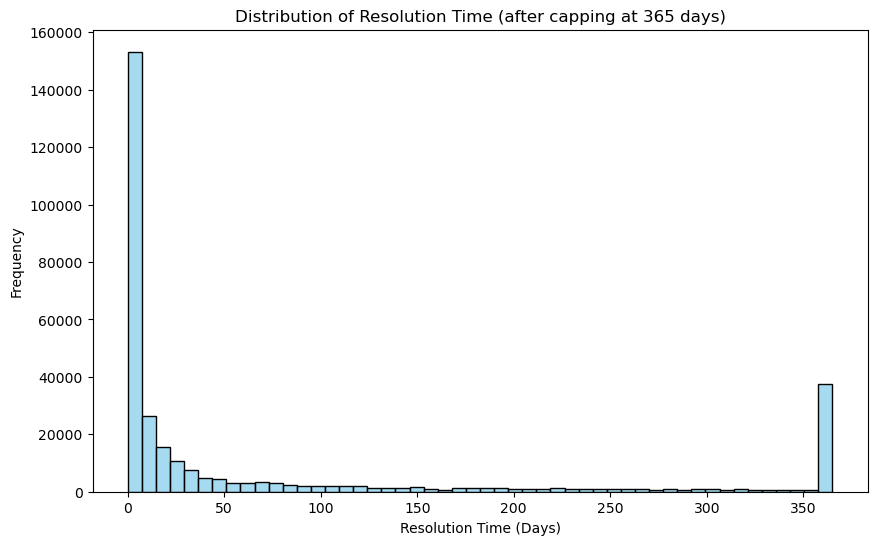

In [55]:
#Analyzing the impact after capping using a histogram

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['resolution_time_filled'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Resolution Time (after capping at 365 days)")
plt.xlabel("Resolution Time (Days)")
plt.ylabel("Frequency")
plt.show()

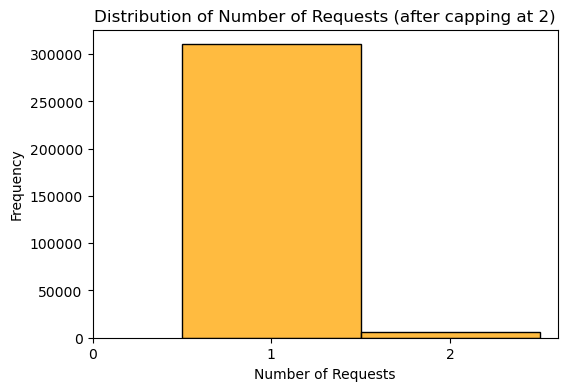

In [59]:
plt.figure(figsize=(6, 4))
sns.histplot(df['num_requests'], bins=3, discrete=True, color='orange', edgecolor='black')
plt.title("Distribution of Number of Requests (after capping at 2)")
plt.xlabel("Number of Requests")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2])
plt.show()

In [61]:
# View count of missing values for all columns
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]  # Show only columns with missing values
print("Missing values by column:")
print(missing_summary)


Missing values by column:
resolution_time    50225
closed_date_et     50225
dtype: int64


In [63]:
# Confirm that resolution_time_filled has no missing values
print(df['resolution_time_filled'].isnull().sum())  # Should be 0

0


In [ ]:
df.to_csv("clean3.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316673 entries, 0 to 316672
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   _id                            316673 non-null  int64  
 1   group_id                       316673 non-null  int64  
 2   num_requests                   316673 non-null  int64  
 3   status_name                    316673 non-null  object 
 4   status_code                    316673 non-null  int64  
 5   dept                           316673 non-null  object 
 6   request_type_id                316673 non-null  int64  
 7   create_date_et                 316673 non-null  object 
 8   last_action_et                 316673 non-null  object 
 9   closed_date_et                 266448 non-null  object 
 10  origin                         316673 non-null  object 
 11  neighborhood                   316673 non-null  object 
 12  council_district              

Missing values by column:
 closed_date_et     50225
resolution_time    50225
dtype: int64


Resolution Time Filled Stats:
count    316673.000000
mean         77.498420
std         125.868921
min           0.000000
25%           1.000000
50%           9.000000
75%          85.000000
max         365.000000
Name: resolution_time_filled, dtype: float64

Num Requests Stats:
count    316673.000000
mean          1.019860
std           0.139518
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: num_requests, dtype: float64



Unique values in 'request_status': ['less than 30 days' 'more than 30 days']
Unique values in 'is_closed': [1 0]
